### If running within a Docker, no action is needed. If not, add the installation path (e.g. 'path_to_fwi2d_directory/local/bin') to the environment variables 'PATH' and 'PYTHONPATH' before running the notebook.

In [1]:
import numpy as np
import math
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seppy

sep = seppy.sep()

In [2]:
# Create a directory to store data
!mkdir -p data
datapath = "./data/"

### Generate source time function (Ricker wavelet)

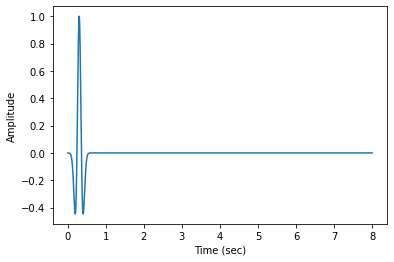

In [3]:
nt=2001
dt=0.004
ot=0
wc=0.03
sigma=math.sqrt(2)/(math.pi*wc)
src = signal.ricker(2*nt-1, sigma)
src=src[1925:1925+nt]
src=src*1.0/np.max(src)

plt.plot(np.linspace(ot,(nt-1)*dt,nt),src)
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude")
plt.show()

In [4]:
# save source wavelet to SEPlib format
sep.write_file(datapath+"wavelet.H", src, ds=np.array([dt]), os=np.array([ot]), dpath=datapath)

### Generate a simple elastic VTI model

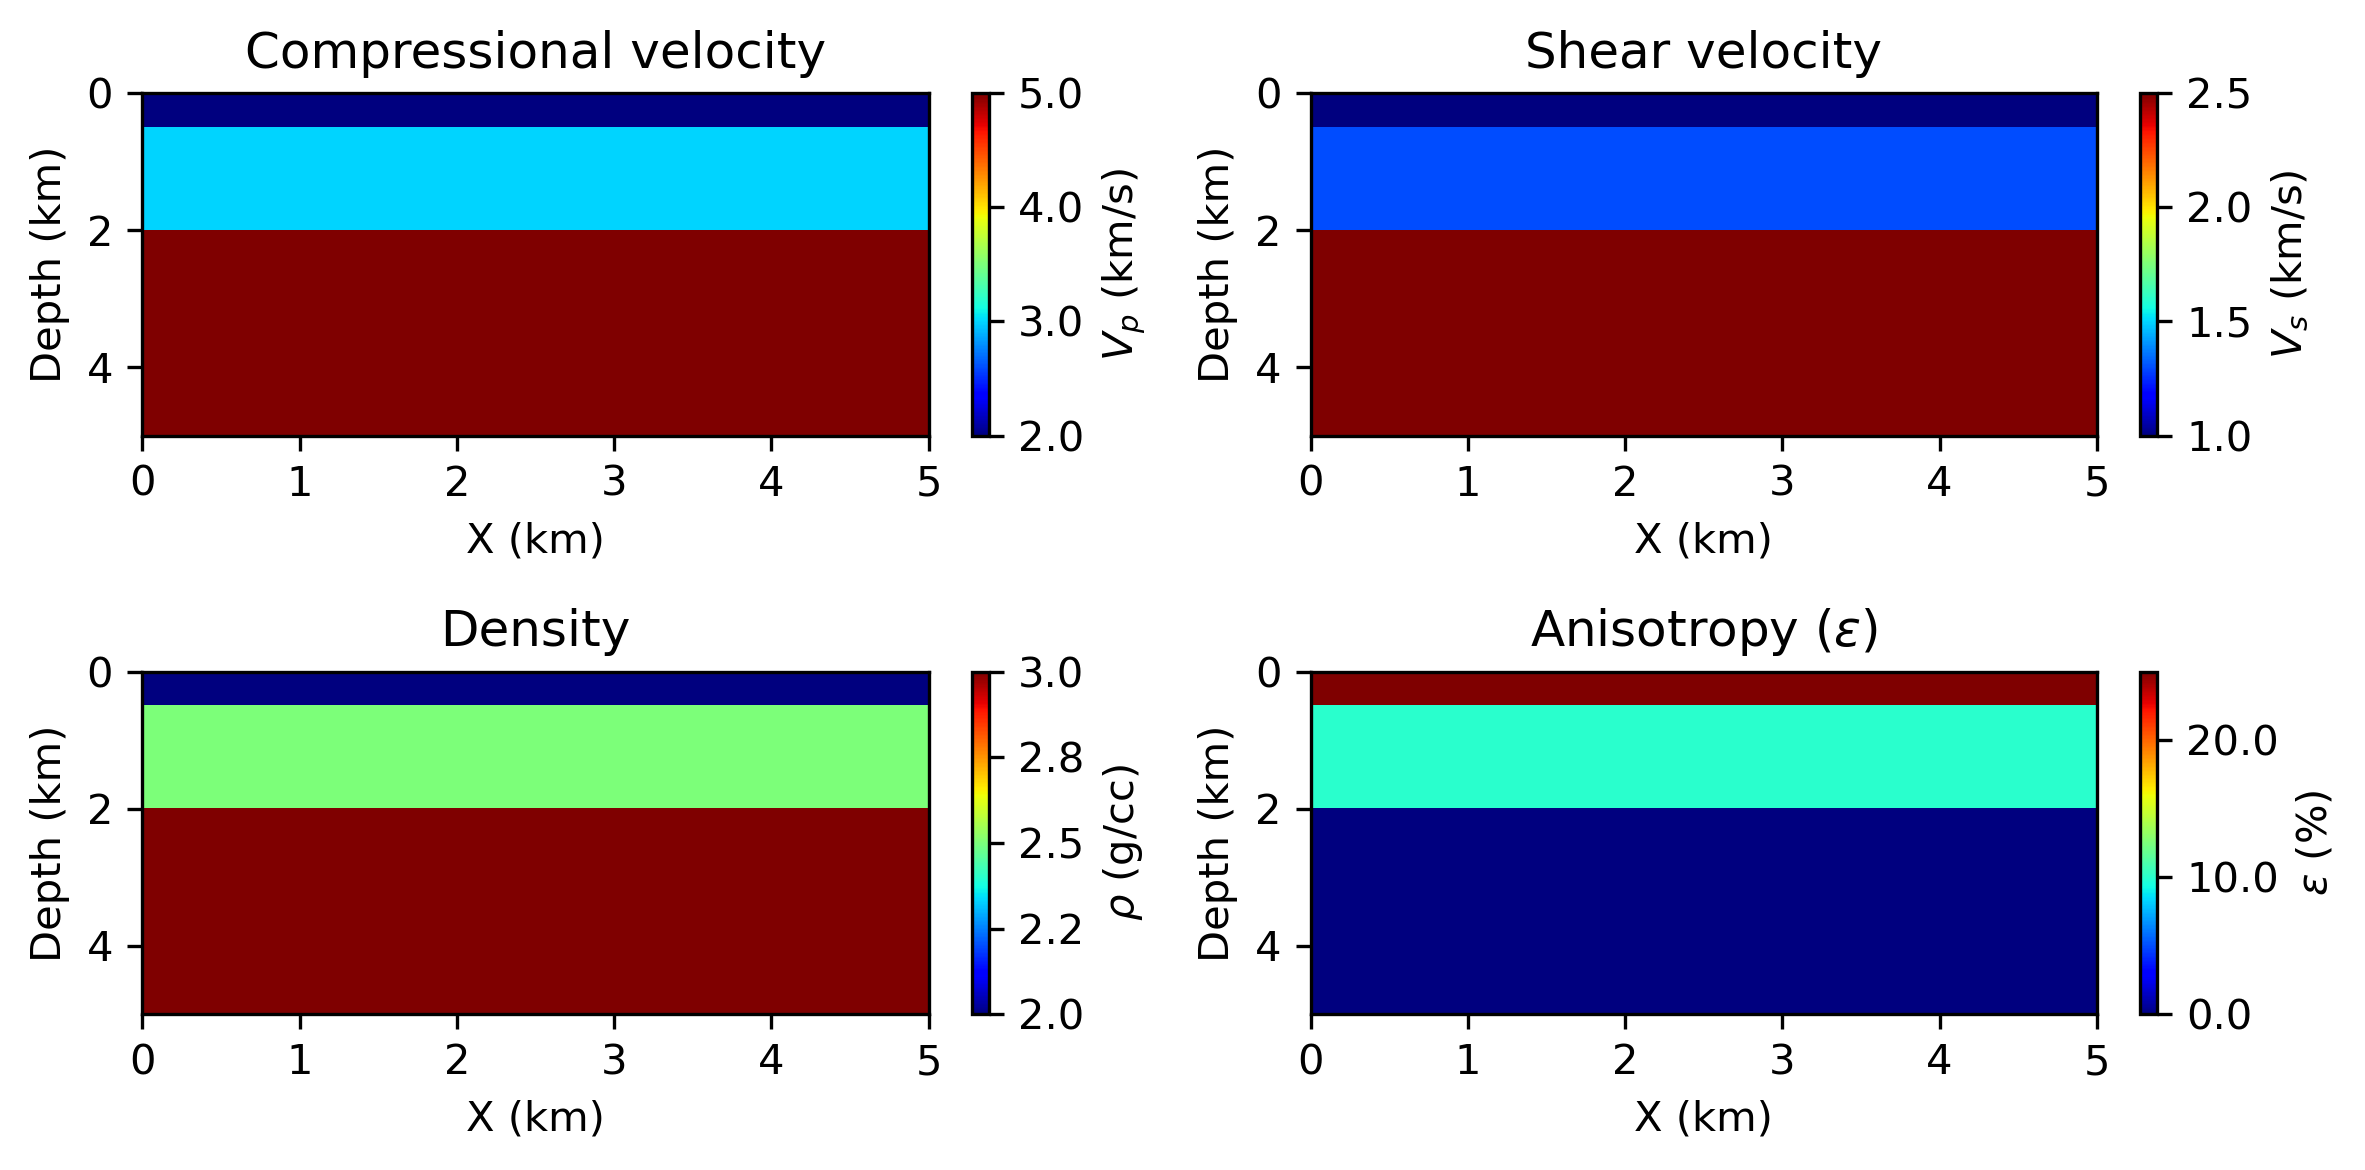

In [23]:
emodel=np.zeros((5,501,501))
emodel[0,:,0:50]=2. # Vp in km/s
emodel[0,:,50:200]=3.
emodel[0,:,200:]=5.
emodel[1,:,0:50]=1 # Vs in km/s
emodel[1,:,50:200]=1.3
emodel[1,:,200:]=2.5
emodel[2,:,0:50]=2. # Density in g/cc
emodel[2,:,50:200]=2.5
emodel[2,:,200:]=3.
emodel[3,:,0:50]=0.15 # Delta in % (Thomsen parameters)
emodel[3,:,50:200]=0.075
emodel[3,:,200:]=0.
emodel[4,:,0:50]=0.25 # Epsilon in % (Thomsen parameters)
emodel[4,:,50:200]=0.1
emodel[4,:,200:]=0.

plt.figure(figsize=(8,4),dpi=300)
plt.subplot(2,2,1)
plt.imshow(np.transpose(emodel[0,:,:]),interpolation='none',aspect="auto",extent=[0,5,5,0],cmap='jet')
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.colorbar(fraction=0.04, format='%.'+str(1)+'f',label=r'$V_p$ (km/s)')
plt.title("Compressional velocity")

plt.subplot(2,2,2)
plt.imshow(np.transpose(emodel[1,:,:]),interpolation='none',aspect="auto",extent=[0,5,5,0],cmap='jet')
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.colorbar(fraction=0.04, format='%.'+str(1)+'f',label=r'$V_s$ (km/s)')
plt.title("Shear velocity")

plt.subplot(2,2,3)
plt.imshow(np.transpose(emodel[2,:,:]),interpolation='none',aspect="auto",extent=[0,5,5,0],cmap='jet')
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.colorbar(fraction=0.04, format='%.'+str(1)+'f',label=r'$\rho$ (g/cc)')
plt.title("Density")

plt.subplot(2,2,4)
plt.imshow(100*np.transpose(emodel[4,:,:]),interpolation='none',aspect="auto",extent=[0,5,5,0],cmap='jet')
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.colorbar(fraction=0.04, format='%.'+str(1)+'f',label=r'$\epsilon$ (%)')
plt.title(r'Anisotropy ($\epsilon$)')

plt.tight_layout()

In [24]:
# save the model in SEPlib format
dx=0.01 # in km
dz=0.01 # in km
ox=0 # in km 
oz=0 # in km 
sep.write_file(datapath+"emodel.H", np.transpose(emodel), ds=np.array([dz,dx,1]), os=np.array([oz,ox,0]), dpath=datapath)

### Forward modeling
The modeling parameters can be provided via a parameter file (as below) but they can also be given directly inline. A combination of the two is also admissible but the command line arguments will override the parameter file if the same parameter is provided in both. Check the parameter file for a description of each parameter. Input and output files must be provided directly inline. The full wavefield can also be output.

The log information can be saved into a file. By default it will print to the command line.

In [25]:
# peek into the parameter file
!cat ./par/elastic_modeling.p

# time parameters
courant=0.6
dt=-1
fmax=10
resampling=sinc
sinc_half_length=11
sub=0

# sources and receivers geometry
srcoord=./par/srcoord.txt

# source mechanism and receiver type
mt=1
fangle=0
mxx=0
mzz=0
mxz=1
seismotype=1
gl=0

# boundary parameters
bc_top=1
bc_bottom=2
bc_left=2
bc_right=2
taper_top=0
taper_left=30
taper_right=30
taper_bottom=30
taper_strength=0.05

# model bounds
vpmin=0.2
vpmax=8
vsmin=0.1
vsmax=5
rhomin=0 
rhomax=8
deltamin=-0.5
deltamax=1
epsilonmin=-0.5
epsilonmax=1

# miscallenous
device=0
nthreads=24
verbose=3
format=0

In [26]:
# run the modeling of particle velocity receivers
!WE_MODELING.x source=./data/wavelet.H model=./data/emodel.H output=./data/elastic_data.H datapath=${PWD}/data/ parfile=./par/elastic_modeling.p

--------------------------------------------------------------------------
[[46946,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: vision

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------

Size of MPI communicator = 1 ; current rank = 0

Fri Jun  2 15:47:32 2023


 Subsurface model geometry
xmin=0.00000 km, xmax=5.00000 km, dx=0.01000 km, nx=501
zmin=0.00000 km, zmax=5.00000 km, dz=0.01000 km, nz=501

 Boundary conditions
Top boundary condition = free surface	 taper size = 0	 taper type = none
Bottom boundary condition = locally absorbing	 taper size = 30	 taper type = cosine squared
Left boundary condition = locally absorbing	 taper size = 30	 taper type = cosine squ

In [27]:
# run the modeling of DAS data (strain rate every meter with 10 m gauge length) at the surface
!WE_MODELING.x source=./data/wavelet.H model=./data/emodel.H output=./data/das_data.H datapath=${PWD}/data/ parfile=./par/das_modeling.p

--------------------------------------------------------------------------
[[46799,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: vision

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------

Size of MPI communicator = 1 ; current rank = 0

Fri Jun  2 15:48:00 2023


 Subsurface model geometry
xmin=0.00000 km, xmax=5.00000 km, dx=0.01000 km, nx=501
zmin=0.00000 km, zmax=5.00000 km, dz=0.01000 km, nz=501

 Boundary conditions
Top boundary condition = free surface	 taper size = 0	 taper type = none
Bottom boundary condition = locally absorbing	 taper size = 30	 taper type = cosine squared
Left boundary condition = locally absorbing	 taper size = 30	 taper type = cosine squ

In [28]:
# load, and plot
axes_data, data = sep.read_file(datapath+"elastic_data.H")
edata = data.reshape(axes_data.n,order='F').T
edata=np.reshape(edata,(2,2,5,nt)) # 2 shots, 2 components, 5 receivers, nt time samples

axes_data, data = sep.read_file(datapath+"das_data.H")
dasdata = data.reshape(axes_data.n,order='F').T

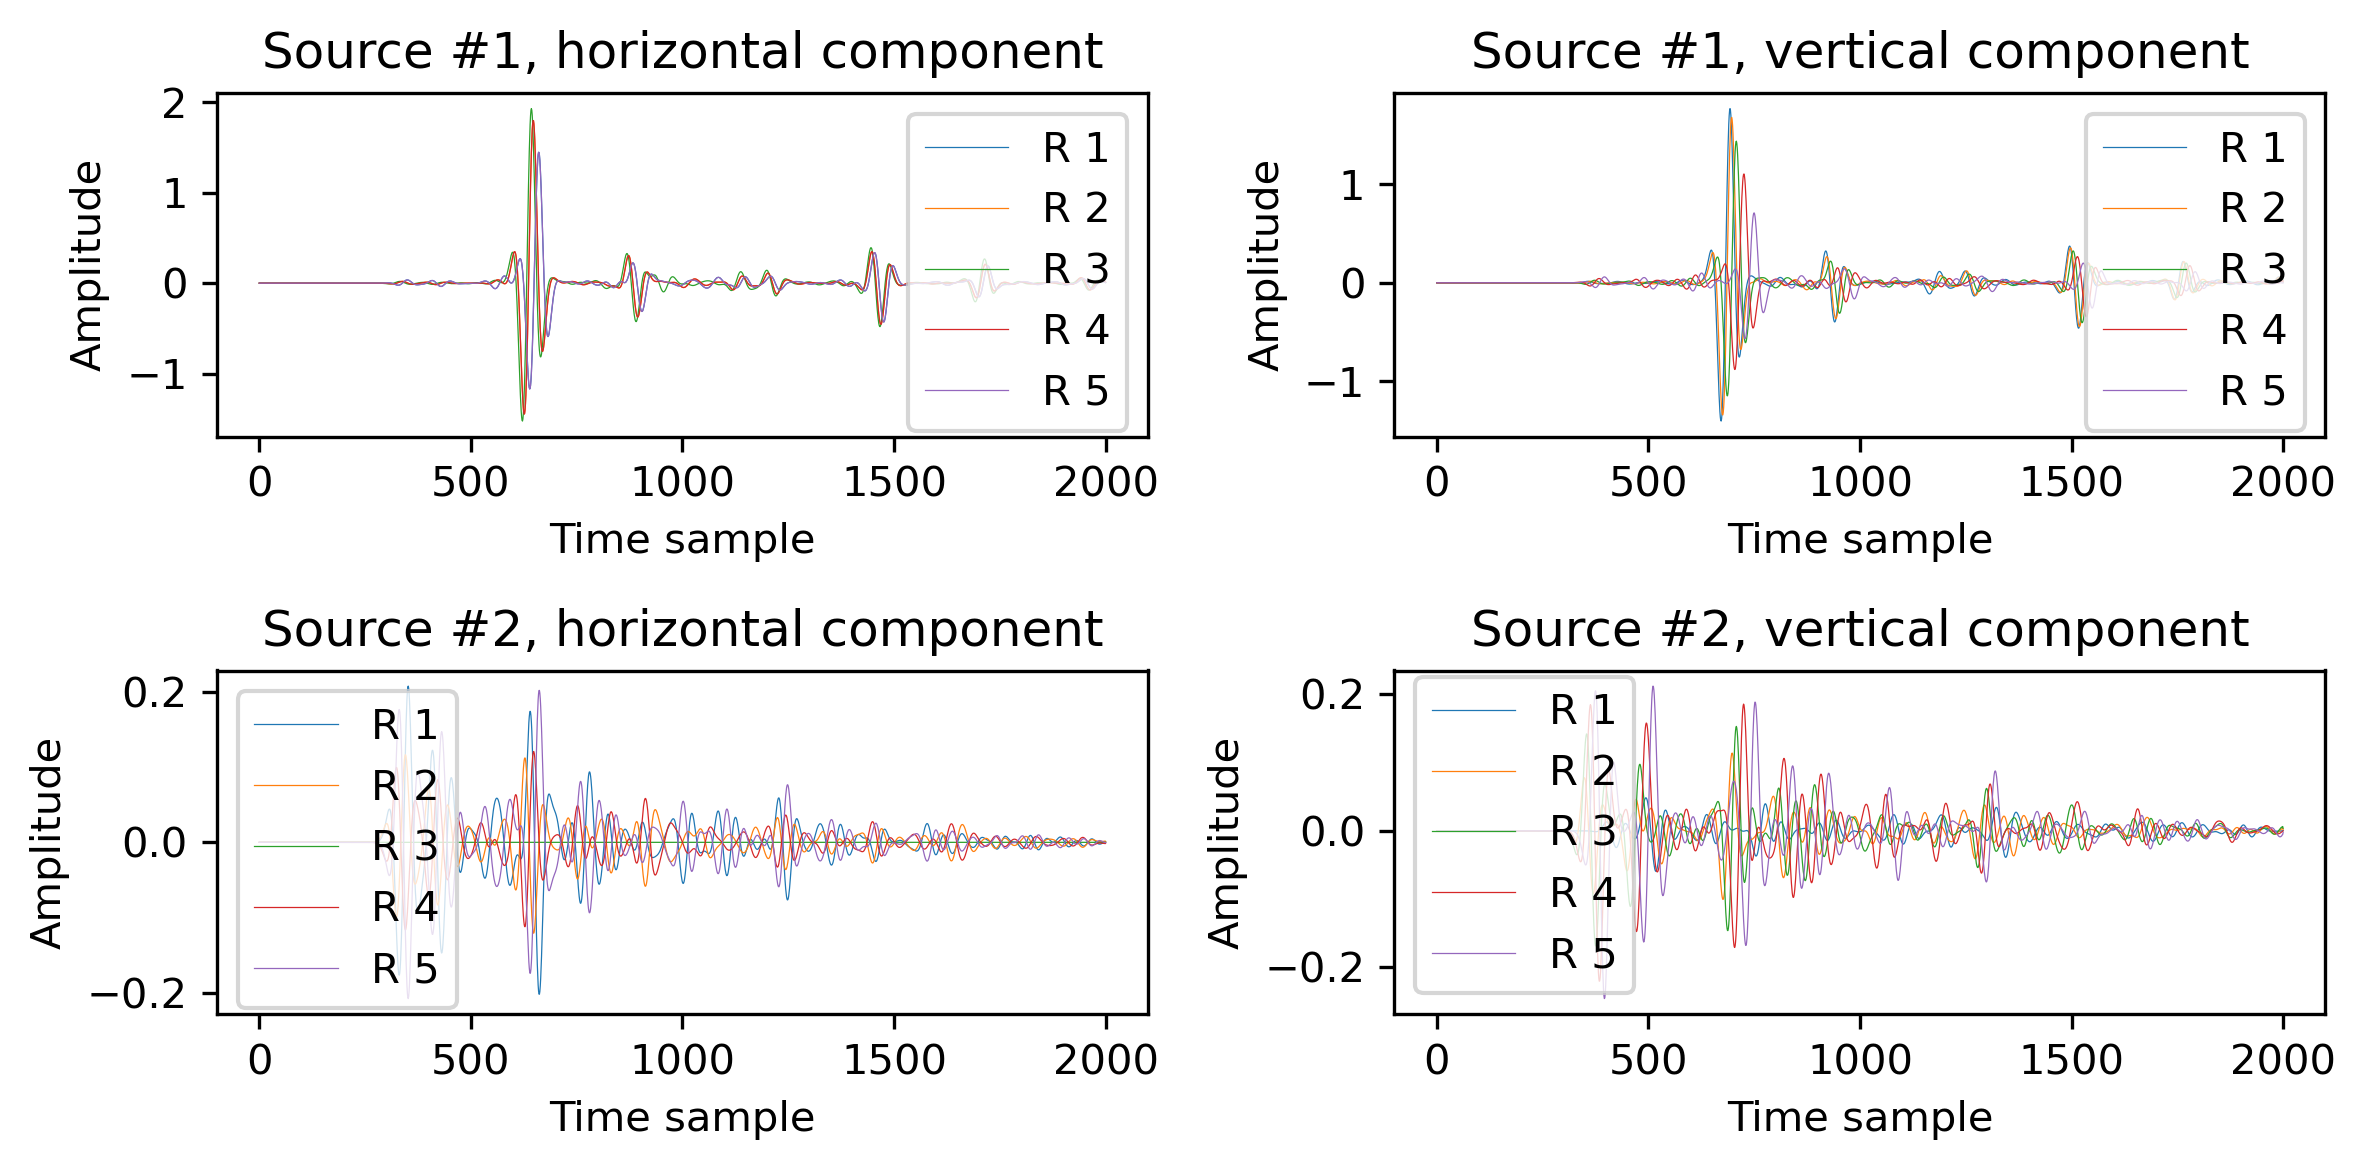

In [29]:
plt.figure(figsize=(8,4),dpi=300)
plt.subplot(2,2,1)
for i in range(5):
    label="R "+str(i+1)
    plt.plot(edata[0,0,i,:],LineWidth=0.3,label=label)
plt.legend()
plt.xlabel('Time sample')
plt.ylabel('Amplitude')
plt.title("Source #1, horizontal component")

plt.subplot(2,2,2)
for i in range(5):
    label="R "+str(i+1)
    plt.plot(edata[0,1,i,:],LineWidth=0.3,label=label)
plt.legend()
plt.xlabel('Time sample')
plt.ylabel('Amplitude')
plt.title("Source #1, vertical component")

plt.subplot(2,2,3)
for i in range(5):
    label="R "+str(i+1)
    plt.plot(edata[1,0,i,:],LineWidth=0.3,label=label)
plt.legend()
plt.xlabel('Time sample')
plt.ylabel('Amplitude')
plt.title("Source #2, horizontal component")

plt.subplot(2,2,4)
for i in range(5):
    label="R "+str(i+1)
    plt.plot(edata[1,1,i,:],LineWidth=0.3,label=label)
plt.legend()
plt.xlabel('Time sample')
plt.ylabel('Amplitude')
plt.title("Source #2, vertical component")

plt.tight_layout()

Text(0.5, 1.0, 'DAS data')

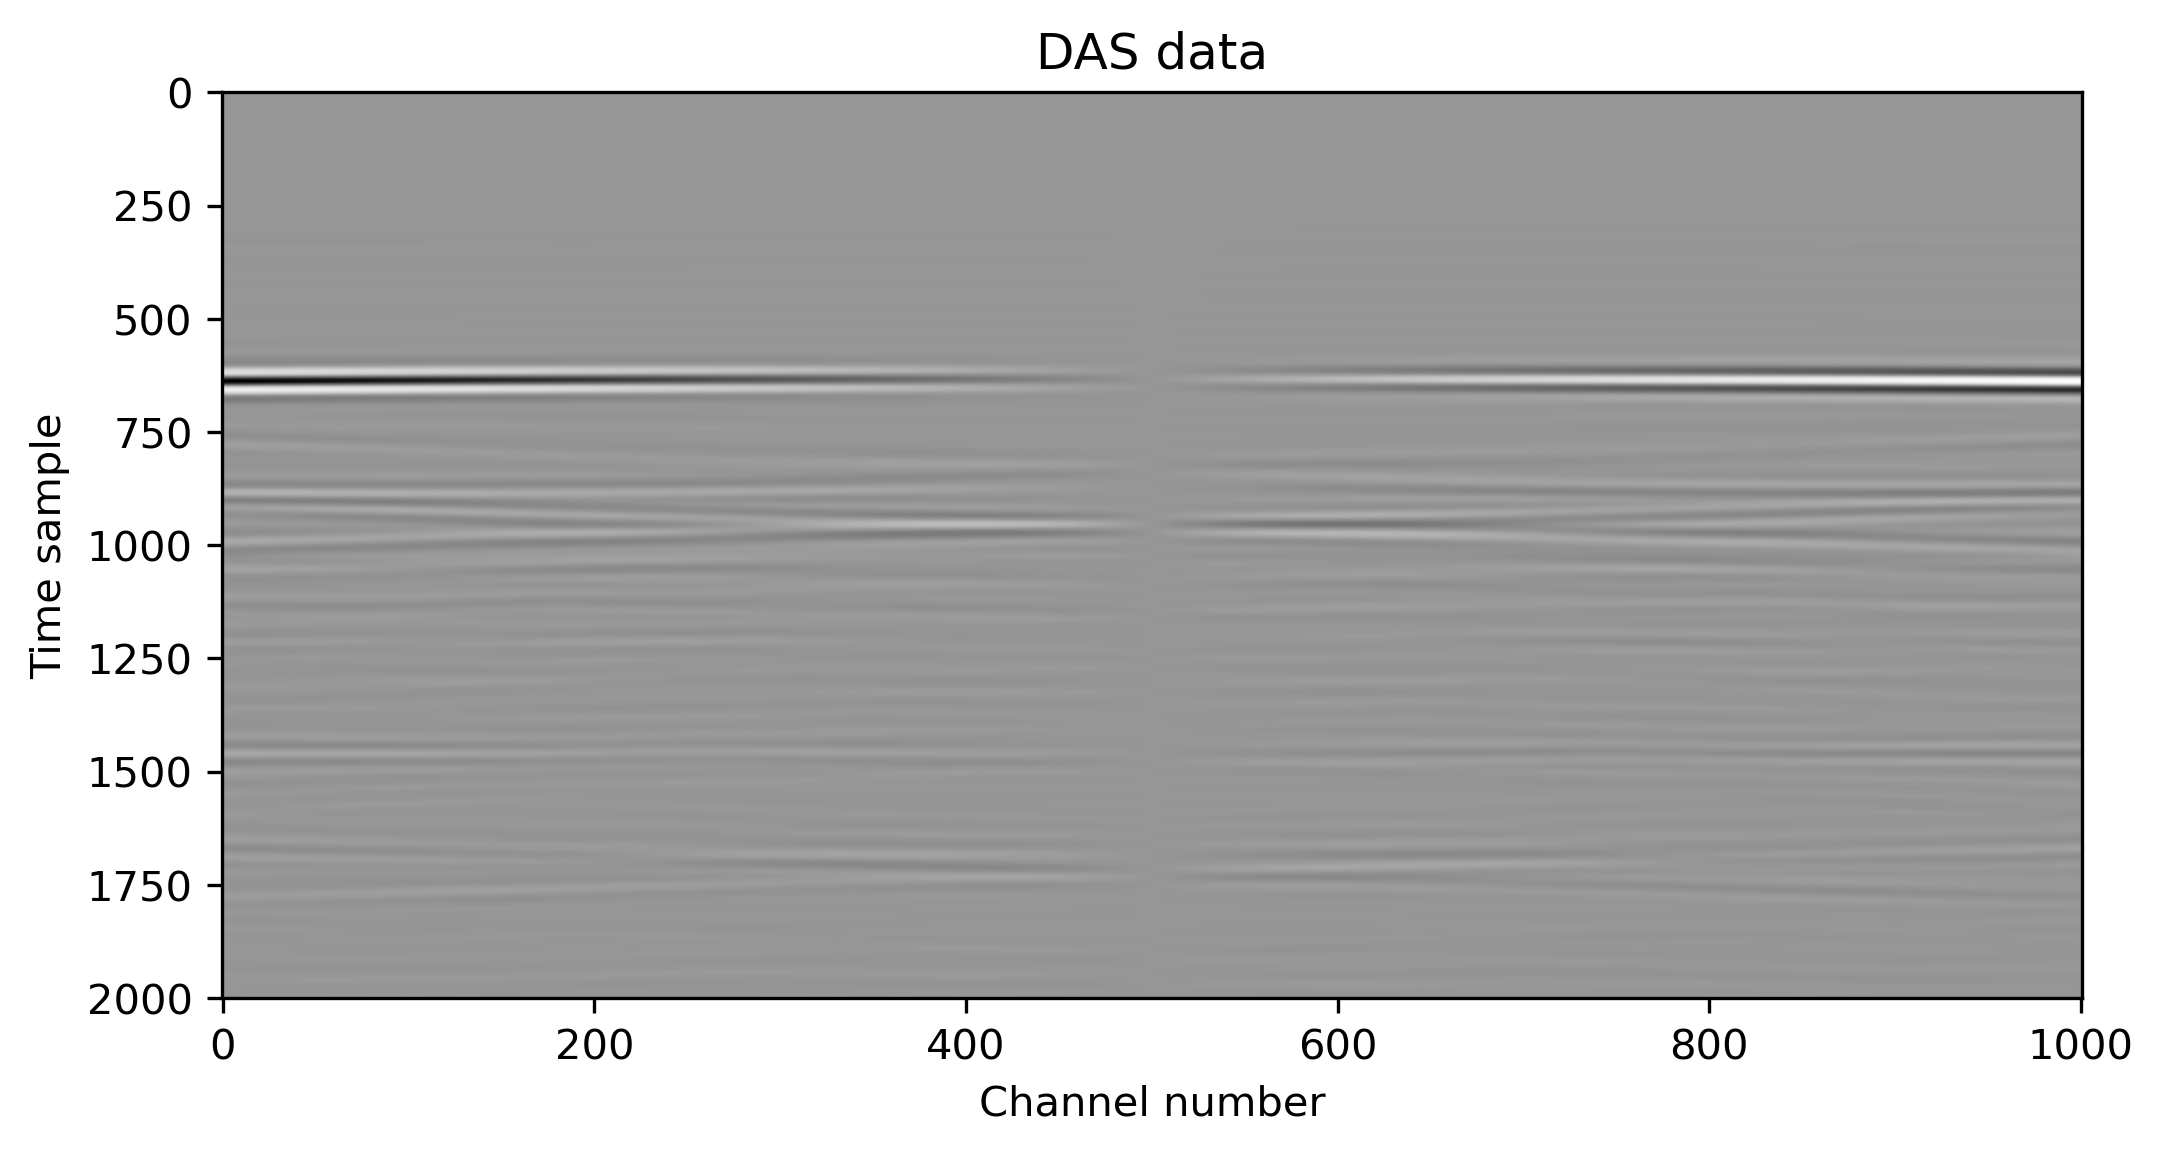

In [30]:
plt.figure(figsize=(8,4),dpi=300)
plt.imshow(np.transpose(dasdata[:,:]),interpolation='bilinear',aspect="auto",cmap='Greys')
plt.xlabel('Channel number')
plt.ylabel('Time sample')
plt.title("DAS data")

Clean up the data directory

In [32]:
!rm -rf data